In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow
from  keras.models import Sequential, Model
from  keras.layers import Input, Dense, LeakyReLU, Activation, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, InputLayer, Flatten, BatchNormalization, Reshape, Lambda

from  keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from  keras.applications.vgg16 import VGG16, preprocess_input
#from  keras.applications import ResNet152V2,ResNet101V2,ResNet50V2 
#from  keras.applications.resnet_v2 import preprocess_input 

from  keras.optimizers import RMSprop, Adam, Adadelta
from  keras.preprocessing.image import load_img, ImageDataGenerator
from  keras.utils import multi_gpu_model
from IPython.display import Image 

import keras_metrics
import pandas
import ast
import numpy as np
import matplotlib.patches as patches 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageDraw,ImageFont

Using TensorFlow backend.


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import keras.backend as K
import numpy as np
import random

In [4]:
from skimage import color
from skimage import io

def custom_preprocess_input(img):
    #plt.imshow((img).astype(np.uint8), vmin=0, vmax=255)
    #plt.show()
    #print(img.shape)
    #img_pil = Image.fromarray(img.astype(np.uint8)).convert('LA')
    #img = color.rgb2gray(img_pil)
    #img = np.array(img_pil)
    print(img.shape)
    img_test = np.reshape(img, (224,224))
    #print(img.shape)
    plt.imshow(img_test.astype(np.uint8), cmap='Greys_r',vmin=0, vmax=255)
    plt.show()
    #img = img.astype('float64')
    #img /= 255.0
    return img

In [5]:
BATCH_SIZE = 32
IMG_SIZE = 224

In [28]:
train_df = pandas.read_csv("/data01/ML/dataset/FACE_CLASSIFIER/train.csv")
valid_df = pandas.read_csv("/data01/ML/dataset/FACE_CLASSIFIER/val.csv")
test_df = pandas.read_csv("/data01/ML/dataset/FACE_CLASSIFIER/test.csv")

In [29]:
train_df.head(3)

,image_path,face
0,/data01/ML/dataset/FACE_CLASSIFIER/256_ObjectC...,0
1,/data01/ML/dataset/FACE_CLASSIFIER/256_ObjectC...,0
2,/data01/ML/dataset/FACE_CLASSIFIER/256_ObjectC...,0


def convert_paths(path_string):
    temp = path_string.replace("\\", "/")  
    return "/data01/ML/" + temp.split("/",1)[1]

train_df["image_path"] = train_df["image_path"].apply(convert_paths)
valid_df["image_path"] = valid_df["image_path"].apply(convert_paths)
test_df["image_path"] = test_df["image_path"].apply(convert_paths)

In [30]:
train_df.head(3)

,image_path,face
0,/data01/ML/dataset/FACE_CLASSIFIER/256_ObjectC...,0
1,/data01/ML/dataset/FACE_CLASSIFIER/256_ObjectC...,0
2,/data01/ML/dataset/FACE_CLASSIFIER/256_ObjectC...,0


In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")
    #preprocessing_function = custom_preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=None,
        x_col="image_path",
        y_col="face",
        class_mode="raw",
        shuffle=True,
        color_mode = 'rgb',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)

valid_generator = train_datagen.flow_from_dataframe(
        dataframe=valid_df,
        directory=None,
        x_col="image_path",
        y_col="face",
        class_mode="raw",
        shuffle=True,
        color_mode = 'rgb',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)

Found 29592 validated image filenames.
Found 5224 validated image filenames.


count = 0 
for el in train_generator: 
    count = count +1 
    image = el[0][0]
    print(image.shape)
    classf = el[1][0]
    print(classf)
    #img_pil = Image.fromarray(image.astype(np.uint8)*255)
    img_test = np.reshape(image, (224,224))
    #print(img.shape)
    plt.imshow(img_test.astype(np.uint8), cmap='Greys_r',vmin=0, vmax=255)
    plt.show()
    if count == 20:
        break

In [10]:
step_size_train = train_generator.samples/train_generator.batch_size
step_size_valid = valid_generator.samples/valid_generator.batch_size

In [11]:
darknetv1 = Sequential()
darknetv1.add(InputLayer(input_shape=(IMG_SIZE,IMG_SIZE,3)))
darknetv1.add(Conv2D(64,3, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(MaxPooling2D(pool_size=(2, 2)))
darknetv1.add(Conv2D(192,3, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(MaxPooling2D(pool_size=(2, 2)))

darknetv1.add(Conv2D(128,1, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(256,3, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(256,1, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(512,3, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(MaxPooling2D(pool_size=(2, 2)))

darknetv1.add(Conv2D(256,1, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(512,3, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(256,1, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(512,3, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(256,1, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(512,3, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(256,1, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(512,3, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(512,1, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(1024,3, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(MaxPooling2D(pool_size=(2, 2)))

darknetv1.add(Conv2D(512,1, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(1024,3, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(512,1, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(1024,3, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))

darknetv1.add(MaxPooling2D(pool_size=(2, 2)))
darknetv1.add(Flatten())

In [12]:
darknetv1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 192)     110784    
_________________________________________________________________
batch_normalization_2 (Batch (None, 112, 112, 192)     768       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 112, 112, 192)    

In [13]:
darknetv1.add(Dense(1024))
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Dropout(0.5))
darknetv1.add(Dense(512))
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Dropout(0.5))
darknetv1.add(Dense(1, activation = "sigmoid"))

In [14]:
darknetv1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 192)     110784    
_________________________________________________________________
batch_normalization_2 (Batch (None, 112, 112, 192)     768       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 112, 112, 192)    

In [15]:
#darknetv1 = multi_gpu_model(darknetv1, gpus=2) #parallelize model

darknetv1.evaluate_generator(valid_generator, steps=step_size_valid, verbose = 1)

In [16]:
darknetv1.compile(optimizer=Adam(lr = 1e-4), loss="binary_crossentropy", metrics=["accuracy"])
#earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
mcp_save = ModelCheckpoint('face_classifier_BN_COLOR.h5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, mode='min')
history = darknetv1.fit_generator(generator=train_generator, epochs=20, steps_per_epoch=step_size_train, validation_data=valid_generator, validation_steps=step_size_valid, verbose=1, callbacks=[mcp_save,reduce_lr_loss])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/20
925/924 [==============================] - 455s 492ms/step - loss: 0.7827 - accuracy: 0.7732 - val_loss: 0.4152 - val_accuracy: 0.7814
Epoch 2/20
925/924 [==============================] - 255s 276ms/step - loss: 0.2645 - accuracy: 0.8983 - val_loss: 0.1195 - val_accuracy: 0.9229
Epoch 3/20
925/924 [==============================] - 255s 275ms/step - loss: 0.2131 - accuracy: 0.9223 - val_loss: 0.1665 - val_accuracy: 0.8103
Epoch 4/20
925/924 [==============================] - 251s 272ms/step - loss: 0.2062 - accuracy: 0.9267 - val_loss: 0.1187 - val_accuracy: 0.9468
Epoch 5/20
925/924 [==============================] - 242s 262ms/step - loss: 0.1668 - accuracy: 0.9422 - val_loss: 0.0027 - val_accuracy: 0.9271
Epoch 6/20
925/924 [==============================] - 246s 266ms/step - loss: 0.1520 - accuracy: 0.9471 - val_loss: 0.0558 - val_accuracy: 0.9447
Epoch 7/20
925/924 [=========

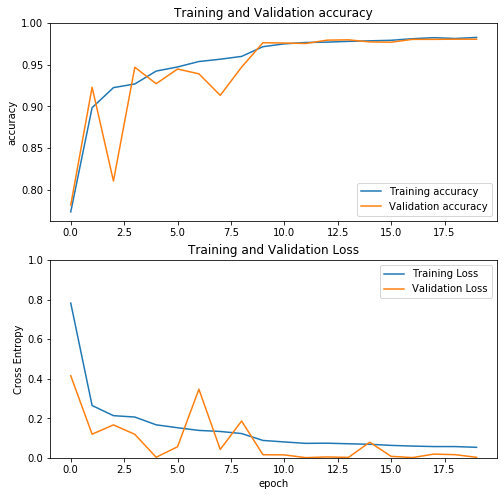

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.ylabel('accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Loading model

In [18]:
darknetv2 = Sequential()
darknetv2.add(InputLayer(input_shape=(IMG_SIZE,IMG_SIZE,1)))
darknetv2.add(Conv2D(64,3, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(MaxPooling2D(pool_size=(2, 2)))
darknetv2.add(Conv2D(192,3, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(MaxPooling2D(pool_size=(2, 2)))

darknetv2.add(Conv2D(128,1, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(256,3, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(256,1, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(512,3, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(MaxPooling2D(pool_size=(2, 2)))

darknetv2.add(Conv2D(256,1, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(512,3, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(256,1, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(512,3, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(256,1, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(512,3, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(256,1, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(512,3, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(512,1, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(1024,3, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(MaxPooling2D(pool_size=(2, 2)))

darknetv2.add(Conv2D(512,1, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(1024,3, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(512,1, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(1024,3, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))

darknetv2.add(MaxPooling2D(pool_size=(2, 2)))
darknetv2.add(Flatten())

darknetv2.add(Dense(1024))
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Dropout(0.5))
darknetv2.add(Dense(512))
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Dropout(0.5))
darknetv2.add(Dense(1, activation = "sigmoid"))

In [19]:
darknetv2.load_weights("face_classifier_BN_GRAYSCALE.h5") 
darknetv2.compile(optimizer=Adam(lr = 1e-4), loss="binary_crossentropy", metrics=["accuracy"])

In [31]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
            dataframe=test_df,
            directory="./",
            x_col="image_path",
            y_col="face",
            class_mode="raw",
            shuffle=False,
            color_mode = 'grayscale',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE)

STEP_SIZE_TEST = test_generator.n / test_generator.batch_size 

perf=darknetv2.evaluate_generator(test_generator,  steps=STEP_SIZE_TEST,  verbose=1)
pred=darknetv2.predict_generator(test_generator,  steps=STEP_SIZE_TEST,  verbose=1)

Found 6147 validated image filenames.
193/192 [==============================] - 29s 148ms/step


In [32]:
print(perf)

[0.3723181486129761, 0.9772246479988098]


500
1000
1500
2000
2500
3000


KeyboardInterrupt: 

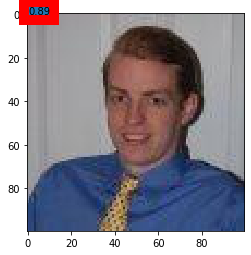

In [34]:
count = 0
for el in zip(pred,test_generator.labels,test_generator.filenames):
    count = count +1
    print(count) if count % 500 == 0 else 0
    #print(el)
    if el[1]==1:
        img = Image.open(el[2])
        plt.imshow(img)
        #img1 = ImageDraw.Draw(img)
        plt.text(0, 0, str(round(el[0][0],2)), bbox=dict(fill=True, edgecolor='red', linewidth=10))
        #font = ImageFont.truetype(50,encoding="unic")
        #text_width, text_height = font.getsize(str(el[0]))
        # get a drawing context
        # draw text, half opacity
        #img1.text((0,0), str(el[0]), font = font, fill=(0,0,0,0))
        #img.show() 
        #plt.show()
        plt.savefig("/home/lorenzo.stacchio/ML/Machine_learning_project/dataset/results/output"+ str(count) + ".png")